In [14]:
import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'cell-images-for-detecting-malaria:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F87153%2F200743%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240414%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240414T144519Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3De044a1ae6708fe299b602393a8f97f0c5f17aae4cc16de67f76dde4c4a5de2cb05631709cbcbbb8ebe194a5aae088af13e0237100b06308ca88d3093667558aa7188466d19bb5a51aa48d357e87c4fc90afe9c2e347900a845e9ac8c825373c90af85967eee19dba1c1afaaca42a3b1f782a53d3ccf4bc7e5cea43c8dc891d698491448bcf5eb359212f52d4f99cd699f24ebc2ece8f6448ed181898b7b8107f14113c1d3c9ffd7dcab48b842cf39d16effd3e2c5a34094e4788f1fcf2640aec32f7a2fd90f14a69a3e14b7e3ecd7c8042b579a10c1a2e45fbf5fac72d67317e7a2d6f6c9a07c5be343f5e74bad4390068f5b5cb029ce8c7d938cd42f507fc52'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')

[==================================================] 708172590 bytes downloaded
Downloaded and uncompressed: cell-images-for-detecting-malaria
Data source import complete.


In [15]:
# file operations
import os
# to list files
import glob

# for numerical analysis
import numpy as np
# to store and process in a dataframe
import pandas as pd

# for ploting graphs
import matplotlib.pyplot as plt
# advancec ploting
import seaborn as sns

# image processing
import matplotlib.image as mpimg

# train test split
from sklearn.model_selection import train_test_split
# model performance metrics
from sklearn.metrics import confusion_matrix, classification_report

# utility functions
from tensorflow.keras.utils import to_categorical, plot_model
# process image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
# sequential model
from tensorflow.keras.models import Sequential
# layers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
# callback functions
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler

In [16]:
# list of files in the dataset
os.listdir('../input/cell-images-for-detecting-malaria/cell_images/cell_images')

['Parasitized', 'Uninfected']

In [17]:
# list all the images in the directory Parasitized
parasitized = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/*.png')

# no. of files in the directory Parasitized
print('No. of files in the directory Parasitized', len(parasitized))

# first few images
parasitized[:5]

No. of files in the directory Parasitized 13779


['../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C179P140ThinF_IMG_20151127_153819_cell_174.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C39P4thinF_original_IMG_20150622_110900_cell_20.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C184P145ThinF_IMG_20151203_104153_cell_151.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C184P145ThinF_IMG_20151203_102543_cell_148.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Parasitized/C91P52ThinF_IMG_20150821_124937_cell_189.png']

In [18]:
# list all the images in the directory Uninfected
uninfected = glob.glob('../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/*.png')

# no. of files in the directory Uninfected
print('No. of files in the directory Uninfected', len(uninfected))

# first few images
uninfected[:5]

No. of files in the directory Uninfected 13779


['../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C58P19thinF_IMG_20150802_122520_cell_161.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C78P39ThinF_IMG_20150606_104936_cell_144.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C94P55ThinF_IMG_20150821_170403_cell_30.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C108P69ThinF_IMG_20150924_224616_cell_102.png',
 '../input/cell-images-for-detecting-malaria/cell_images/cell_images/Uninfected/C55P16thinF_IMG_20150728_121151_cell_15.png']

<ipython-input-21-6ce472a41420>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 10, ind+1)


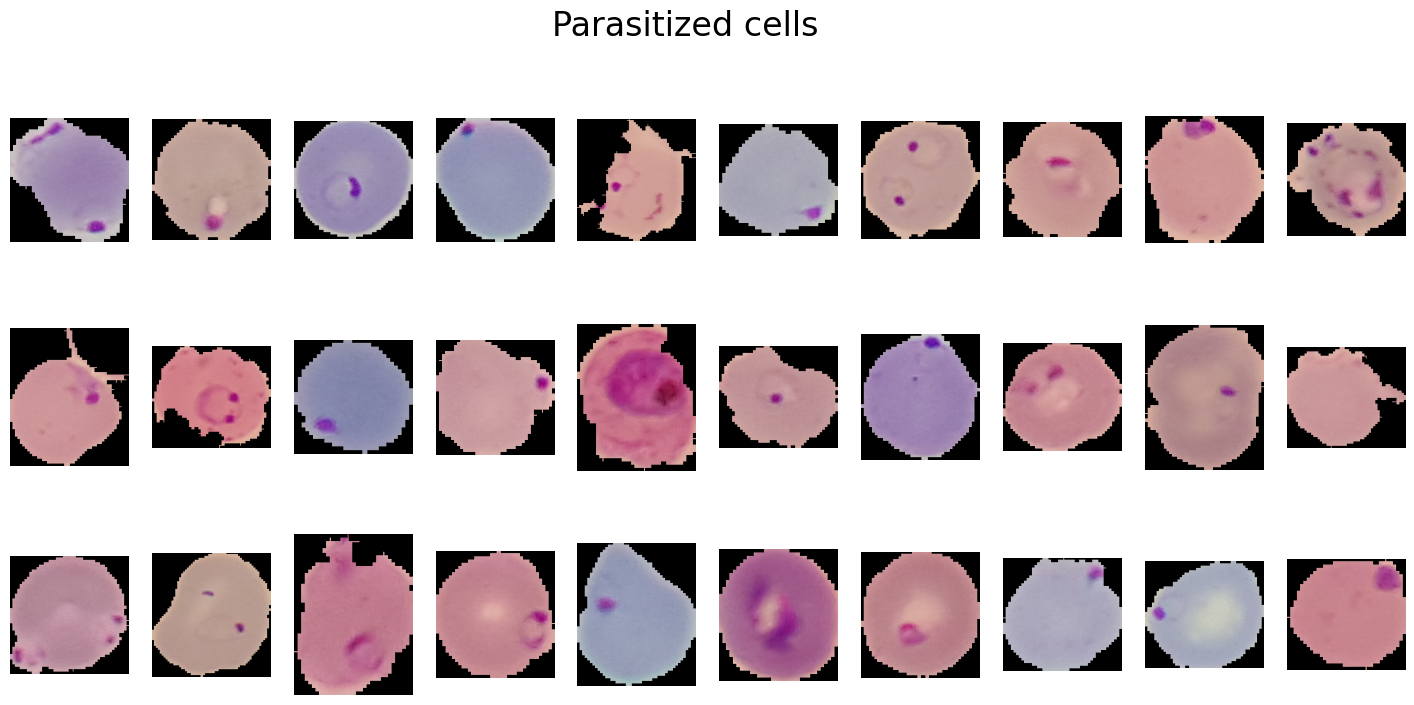

In [21]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Parasitized cells', fontsize=24)

for ind, img_src in enumerate(parasitized[:30]):
    plt.subplot(3, 10, ind+1)
    img = plt.imread(img_src)
    plt.axis('off')
    plt.imshow(img)

<ipython-input-22-bf703d071faf>:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 10, ind+1)


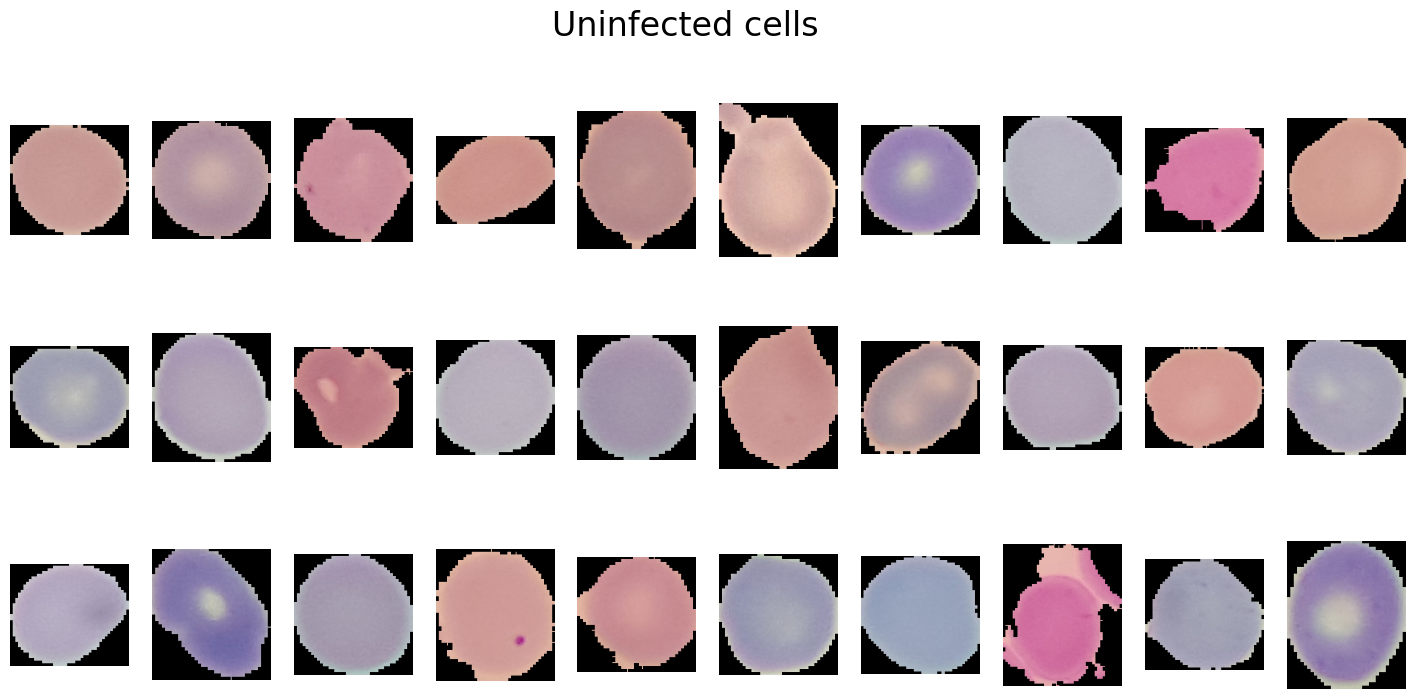

In [22]:
fig, ax = plt.subplots(figsize=(18, 8))
fig.suptitle('Uninfected cells', fontsize=24)

for ind, img_src in enumerate(uninfected[:30]):
    plt.subplot(3, 10, ind+1)
    img = plt.imread(img_src)
    plt.axis('off')
    plt.imshow(img)

In [23]:
BATCH_SIZE = 100  # Number of training examples to process before updating our models variables
IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels
TARGET_SIZE = 64
EPOCHS = 10

In [24]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SHAPE, IMG_SHAPE, 3)))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 74, 74, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 17, 17, 128)      

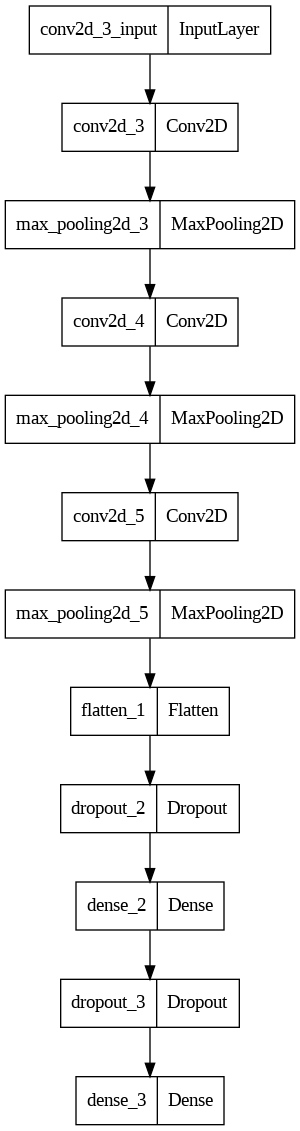

<Figure size 500x1000 with 0 Axes>

In [25]:
plt.figure(figsize=(5, 10))
plot_model(model, to_file="model.png")

In [26]:
datagen = ImageDataGenerator(rescale=1./255,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             vertical_flip=True,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             validation_split=0.3)

train_data = datagen.flow_from_directory('../input/cell-images-for-detecting-malaria/cell_images/cell_images',
                                         target_size=(IMG_SHAPE,IMG_SHAPE),
                                         batch_size=BATCH_SIZE,
                                         shuffle=True,
                                         class_mode='binary',
                                         subset='training')

validation_data = datagen.flow_from_directory('../input/cell-images-for-detecting-malaria/cell_images/cell_images',
                                              target_size=(IMG_SHAPE,IMG_SHAPE),
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              class_mode='binary',
                                              subset='validation')

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


In [27]:
# Instantiate an early stopping callback
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta = 0.01,
                               patience=5)

# Instantiate a model checkpoint callback
model_save = ModelCheckpoint('best_model.hdf5',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True)

In [28]:
history = model.fit(train_data,
                    validation_data=validation_data,
                    epochs=EPOCHS,
                    verbose=1,
                    callbacks=[early_stopping, model_save])

Epoch 1/10
193/193 [==============================] - 1146s 6s/step - loss: 0.6767 - accuracy: 0.5741 - val_loss: 0.5311 - val_accuracy: 0.8125


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/10
193/193 [==============================] - 1118s 6s/step - loss: 0.3367 - accuracy: 0.8807 - val_loss: 0.2551 - val_accuracy: 0.9100
Epoch 3/10
193/193 [==============================] - 1117s 6s/step - loss: 0.2497 - accuracy: 0.9143 - val_loss: 0.2889 - val_accuracy: 0.8807
Epoch 4/10
193/193 [==============================] - 1102s 6s/step - loss: 0.2421 - accuracy: 0.9168 - val_loss: 0.2218 - val_accuracy: 0.9200
Epoch 5/10
193/193 [==============================] - 1027s 5s/step - loss: 0.2251 - accuracy: 0.9264 - val_loss: 0.2080 - val_accuracy: 0.9249
Epoch 6/10
193/193 [==============================] - 1116s 6s/step - loss: 0.2168 - accuracy: 0.9279 - val_loss: 0.2207 - val_accuracy: 0.9234
Epoch 7/10
193/193 [==============================] - 1095s 6s/step - loss: 0.2052 - accuracy: 0.9312 - val_loss: 0.2092 - val_accuracy: 0.9226
Epoch 8/10
193/193 [==============================] - 1081s 6s/step - loss: 0.1975 - accuracy: 0.9342 - val_loss: 0.2159 - val_accuracy:

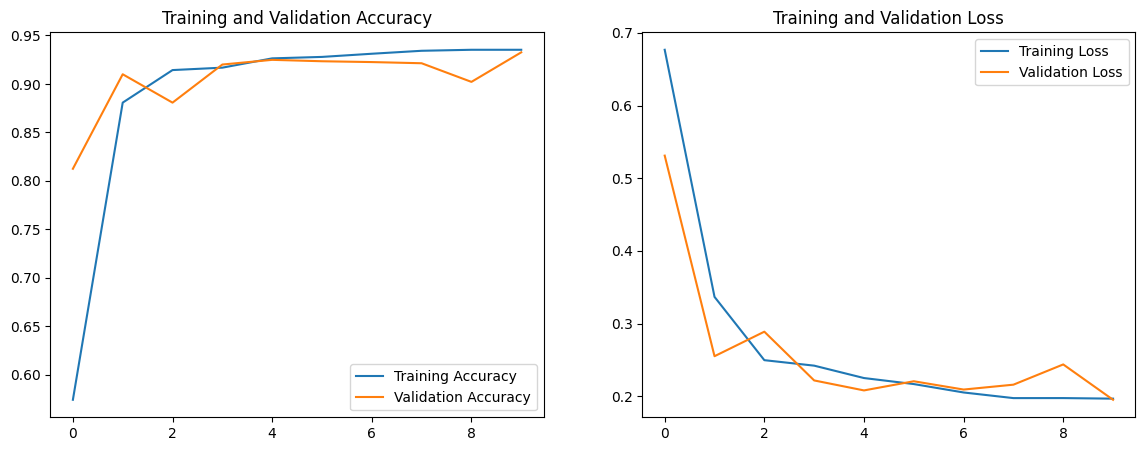

In [29]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()